# Data Preprocessing
### Brendon & Alec Barrios     |     08/08/2020
Using OSIC Pulmonary Fibrosis Progression dataset from Kaggle.com

<https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview>

Adapted from: <https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet>

In [1]:
import os
import glob
import pydicom
import pandas as pd

DATA_DIR = "train/"
patients = os.listdir(DATA_DIR)

labels_df = pd.read_csv("train.csv", index_col=0)

In [11]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 70     # recommended minimum: 70
NUM_SLICES = 30   # recommended minimum: 20
SAVE_FILE = "{}data-{}x{}x{}.npy".format("train", IMG_SIZE, IMG_SIZE, NUM_SLICES)

In [34]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l)/len(l)

def normalize(a):
    a[a < 0] = 0
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm


def process_data(patient, labels_df, img_px_size=80, num_slices=20, visualize=False):
    
    print(patient)
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts images serially
    
    new_slices = []
    slices = [cv2.resize(normalize(each_slice.pixel_array), (img_px_size, img_px_size)) for each_slice in slices]

    chunk_step = math.ceil(len(slices) / num_slices) # (num_slices^2 + 1)/num_slices
    
    # Chunks and averages images for patients with > NUM_SLICES images
    for slice_chunk in chunks(slices, chunk_step):
        avg_slice = list(map(mean, zip(*slice_chunk)))
        new_slices.append(avg_slice)
    
    print("Chunked Slices:", len(new_slices))    
    
    # Handle data with less than num_slices images
    diff = num_slices - len(new_slices)
    if diff:
        for n in range(diff):
            mid = int(len(new_slices) / 2)
            # possibly mirror the duplicate images(?)
            new_slices.append(new_slices[mid])
        
    # Handle data with more than num_slices images
    while len(new_slices) > num_slices:
        new_img = list(map(mean, zip(*[new_slices[-1], new_slices[-2]])))
        del new_slices[num_slices]
        new_slices[num_slices - 1] = new_img
        
    print("  Final Slices:", len(new_slices))
    
    if visualize:
        cols = int(num_slices / 5)
        fig = plt.figure(figsize=(16,12)) # double the default figsize
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(5, cols, num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show
        
    '''
    Obtain slope of FVC Score as label
    Possibly check R^2 values as a counterpart to confidence score
    Check if non-linear functions describe FVC trends better than linear functions
    If so, brainstorm a numeric readout (to replace slope) from the non-linear f(x) that works best
    '''
    FVC = np.array(labels_df.at[patient, "FVC"])
    Weeks = np.array(labels_df.at[patient, "Weeks"])
    m, b = np.polyfit(Weeks, FVC, 1) # y = m*x + b; where x = Weeks, and y = FVC
        
    return np.array(new_slices), -m, b

In [35]:
much_data = []
num_key_errors = 0
num_run_errors = 0
num_attribute_errors = 0

for num, patient in enumerate(patients[:3]):
    if num%100 == 0 and num != 0:
        print(num)
    
    """
    This is a work-around for files that require GDCM to read. Try implementing get_pixeldata() method.
    """      
    try:
        img_data, label, intercept = process_data(patient, 
                                                  labels_df, 
                                                  img_px_size=IMG_SIZE, 
                                                  num_slices=NUM_SLICES, 
                                                  visualize=False)
        
        much_data.append([img_data, label, intercept])
        
    except KeyError:
        print("Unlabeled data!") # error that Sentdex handled
        num_key_errors += 1
        
    except RuntimeError:
        print("GDCM required!") # error that requires GDCM dependency
        num_run_errors += 1
        
    except AttributeError:
        print("Missing ImagePositionPatient!") # use 
        num_attribute_errors += 1
        
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

if num_key_errors:
    print("KeyErrors: {}".format(num_key_errors))
if num_run_errors:
    print("Runtime Errors: {}".format(num_run_errors))
if num_attribute_errors:
    print("Attribute Errors: {}".format(num_attribute_errors))

ID00007637202177411956430
Chunked Slices: 30
  Final Slices: 30
ID00009637202177434476278
Chunked Slices: 29
  Final Slices: 30
ID00010637202177584971671
Chunked Slices: 27
  Final Slices: 30
Save successful!


In [33]:
much_data

[[array([list([[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         7.39646464e-07, 4.56222515e-05, 1.76487053e-04, 4.39066420e-05,
         2.81945144e-04, 1.04605695e-03, 4.41652259e-04, 2.90927609e-05,
         6.34595227e-06, 1.66503287e-04, 8.30655138e-05, 2.84385295e-04,
         8.20042819e-06, 4.42715927e-06, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+

-17.042803238739083
17.042803238739083


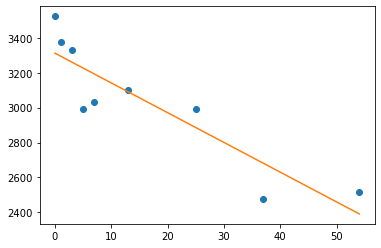

In [15]:
FVC = np.array(labels_df.at[patient, "FVC"])
Weeks = np.array(labels_df.at[patient, "Weeks"])
m, b = np.polyfit(Weeks, FVC, 1)
plt.plot(Weeks, FVC, 'o')
plt.plot(Weeks, m*Weeks + b)
print(m)
print(-m)

In [16]:
"""
Proof of Save/Load states:
"""
images = np.load(SAVE_FILE, allow_pickle=True)

Normalized Image Data:
 [array([9.71704724e-05, 1.30363301e-04, 2.12876388e-04, 1.10955166e-04,
       9.93727658e-05, 1.22330422e-04, 1.03352775e-04, 8.02582715e-05,
       1.05638666e-04, 1.58953822e-04, 6.13366629e-05, 1.07132407e-04,
       1.68345084e-04, 6.33026528e-05, 8.87639426e-05, 1.35267684e-04,
       4.42934460e-05, 9.16071330e-05, 1.38316283e-04, 1.08492707e-04,
       6.07988810e-05, 6.86935846e-05, 7.26869816e-05, 9.74383573e-05,
       8.15697722e-05, 4.56113683e-05, 1.10816394e-04, 1.59206313e-04,
       5.31278853e-05, 7.68963729e-05, 7.18302498e-05, 2.64879228e-04,
       1.39267326e-04, 1.40548577e-04, 5.77773914e-05, 2.02683285e-04,
       9.45128797e-05, 1.69134635e-04, 3.84270736e-05, 1.33597194e-04,
       1.01251229e-04, 6.32155381e-05, 1.30313647e-04, 1.39087418e-04,
       1.24856977e-04, 9.63037963e-05, 1.45212990e-04, 9.00757713e-05,
       8.72482254e-05, 1.00384511e-04, 6.32099237e-05, 1.07190119e-04,
       1.67705009e-04, 1.35540887e-04, 6.86825835e-0

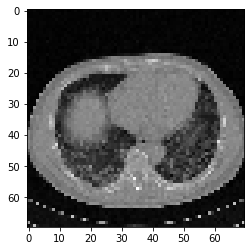

In [17]:
print("Normalized Image Data:\n", images[-1,0][1])
plt.figure()
plt.imshow(images[-1,0][10], cmap='gray')
plt.show()

### Proof of concept: Loading in training data

In [18]:
x_train = []
y_train = []
b = []
for n in range(len(images)):
    x_train.append(images[n, 0])
    y_train.append(images[n, 1])
    b.append(images[n, 2])
X = np.array(x_train)
Y = np.array(y_train)
print(X.shape)
print(Y.shape)
NUM_SLICES*IMG_SIZE**2

ValueError: could not broadcast input array from shape (30,70,70) into shape (30)